In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy import interpolate
from scipy import integrate
from scipy import optimize


import sys
sys.path.append('sim_code/')


#for nice plots
fig_width_pt=347.5
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/(2.0)    # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inlw=2ches
fig_height = fig_width*golden_mean      # height in inches
fig_size = [fig_width,fig_height]
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath} \usepackage{amssymb} \usepackage{siunitx}"]
params = {#'backend': 'pdf',\n",
            'text.usetex': True,
            'font.weight': 'bold',
            'axes.linewidth' : 1.5,
            'axes.labelsize': 18,
            'font.size': 18,
            'legend.fontsize': 16,
            'xtick.labelsize': 18,
            'ytick.direction':'in',
            'xtick.direction':'in',
            'ytick.labelsize': 18,
            'font.family' : 'lmodern',
            #'text.latex.unicode': True,
            'figure.figsize': fig_size}
plt.rcParams.update(params)




/home/hendrykn123/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/hendrykn123/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:64: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


<ipython-input-1-3b4334e0fa28>:22: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath} \usepackage{amssymb} \usepackage{siunitx}"]


This Notebook demonstrates the typical Markovian embedding procedure for modelling a one-dimensional time series trajectory. For reference we refer to: https://www.pnas.org/doi/abs/10.1073/pnas.2023856118. Note that the authors used a multi-exponential Ansatz for the memory kernel. Here we demonstrate the same algorithm for the sample trajectory, but we use a multi-exponential-oscillatory Ansatz, as suggested in: https://pubs.acs.org/doi/full/10.1021/acs.jpcb.1c09481.

### Load Trajectory
The trajectory is itself generated from a Markovian embedding scheme. Just use your trajectory with constant time step instead.

Text(0, 0.5, '$x$ [nm]')

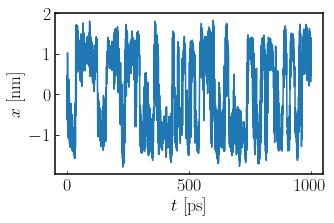

In [2]:
x = np.load('test.npy') #units are nm and ps
dt=0.01 #ps


t = np.arange(0, len(x)*dt, dt)
plt.plot(t[:100000],x[:100000])
plt.xlabel(r'$t$ [ps]')
plt.ylabel(r'$x$ [nm]')

### Extract Memory Kernel

With the Volterra scheme suggested in https://www.pnas.org/doi/abs/10.1073/pnas.2023856118

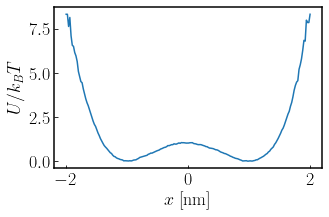

In [3]:
#compute the free energy
kT=2.494 #kcal/mol
hist,edges=np.histogram(x , bins=200, density=True)
pos =(edges[1:]+edges[:-1])/2
fe = -np.log(hist)*kT

pos = pos[fe !=np.inf]
fe = fe[fe !=np.inf]
fe-=np.min(fe)

plt.plot(pos,fe/kT)
plt.ylabel(r'$U/k_BT$')
plt.xlabel(r'$x$ [nm]')
plt.show()

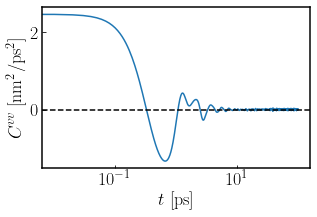

1.0109656720713418


In [4]:
# compute the correlation functions
from correlation import *

#compute velocity acf
trunc = 100
dt=0.01 #ps
kT=2.494
v=np.gradient(x,dt)
tmax = int(trunc/dt)
corrv = correlation(v)[:tmax]
t_corr = np.arange(0,len(corrv)*dt,dt)

plt.plot(t_corr,corrv)
plt.xscale('log')
plt.xlabel(r'$t$ [ps]')
plt.ylabel(r'$C^{vv}$ [nm$^2$/ps$^2$]')
plt.axhline(y=0,color='k',linestyle='--')
plt.show()

#compute mass via equipartition theorem
mass = kT/corrv[0]

print(mass)

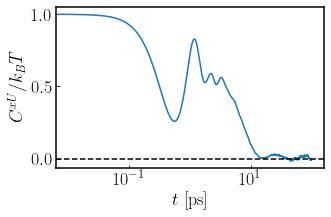

2.4917900881328374

In [5]:
#compute xdU corr (via histogram and splines)
def compute_mean_force(pos,fe,x): 

    #cubic splines
    fe_spline=interpolate.splrep(pos, fe, s=0, per=0)
    force_array=interpolate.splev(x, fe_spline, der=1)

    return force_array



force_array = compute_mean_force(pos,fe,x)


corrxU= correlation(x,force_array)[:tmax]

plt.plot(t_corr,corrxU/kT)
plt.xscale('log')
plt.xlabel(r'$t$ [ps]')
plt.ylabel(r'$C^{xU}/k_BT$')
plt.axhline(y=0,color='k',linestyle='--')
plt.show()

corrxU[0]

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


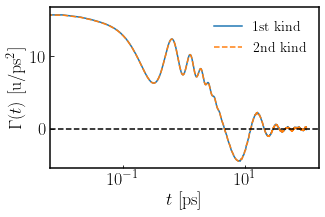

In [6]:
#Volterra extraction scheme (G-Method)
def compute_kernel(dt, v_acf,xU_cf,mass,trunc,first_kind=True):
    kernel_i = np.zeros(min(len(v_acf),trunc))
    
    prefac = 1/v_acf[0]
    for i in range(1,len(kernel_i)):
        if first_kind:
            kernel_i[i] -= np.sum(kernel_i[:i]*(v_acf[1:i+1])[::-1])
            kernel_i[i] -= mass*(v_acf[i]-v_acf[0])/dt
            kernel_i[i] -= xU_cf[0]/dt
            kernel_i[i] += xU_cf[i]/dt
            kernel_i[i] =  kernel_i[i]*prefac*2
        else:
            kernel_i[i]  -= np.sum(kernel_i[:i]*(v_acf[1:i+1])[::-1])
            kernel_i[i]  -= xU_cf[0]/v_acf[0]*v_acf[i]/dt
            kernel_i[i]  += xU_cf[i]/dt
            kernel_i[i]  = kernel_i[i]*prefac*2
            

    kernel  = np.gradient(kernel_i,dt)  
    kernel_index = np.arange(0,len(kernel)*dt,dt)
    return kernel_index, kernel, kernel_i

t, kernel, ikernel = compute_kernel(dt, corrv,corrxU,mass,trunc=10000,first_kind=True)
t2, kernel2, ikernel2 = compute_kernel(dt, corrv,corrxU,mass,trunc=10000,first_kind=False)

plt.plot(t,kernel,label='1st kind')
plt.plot(t2,kernel2,'--',label='2nd kind',)
plt.xscale('log')
plt.xlabel('$t$ [ps]')
plt.ylabel('$\Gamma(t)$ [u/ps$^2$]')
plt.axhline(y=0,linestyle='--',color='k')
plt.legend(loc='best',frameon=False,fontsize=14)

### Fit the Memory Kernel
With the parameterization suggested in 

No handles with labels found to put in legend.


/home/hendrykn123/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/hendrykn123/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


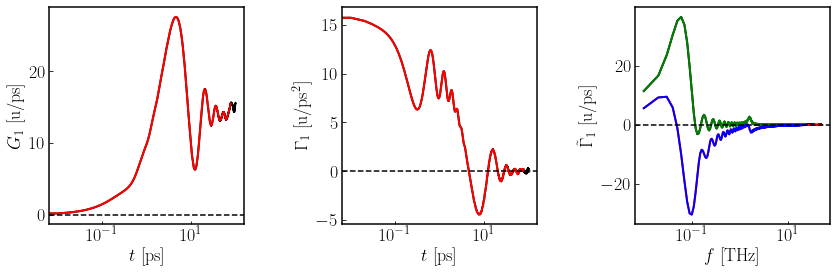

In [7]:
sys.path.append('../../GLE_Prediction/generell_stuff')
from filon_fft import *


t = np.arange(0,len(kernel)*dt,dt)

start = 0
end =3.89
amount = 10000

#create logspaced data
logsp = np.append(0,np.unique(np.logspace(start,end,amount).astype(int)))
t_logsp = t[logsp]
ikernel_logsp = ikernel[logsp]
kernel_logsp = kernel[logsp]

#compute FFT, better in fitting oscillations in memory kernels
n=int(len(kernel)/10)
omega,kernel_ft = fourier_integrate(t,np.append(kernel[:n],np.zeros(len(kernel)-n)))
freqs=omega/2/np.pi
kernel_ft = kernel_ft[freqs >0]
freqs= freqs[freqs >0]
#kernel_ft = gaussian_filter1d(np.real(kernel_ft), 5) + 1j*gaussian_filter1d(np.imag(kernel_ft), 5) 

start = 0
end =3.39
amount = 10000
logsp = np.append(0,np.unique(np.logspace(start,end,amount).astype(int)))
freqs_logsp = freqs[logsp]
kernel_ft_logsp = kernel_ft[logsp]


fig, ax = plt.subplots(1,3, figsize=(14,4))
plt.subplots_adjust(wspace = 0.5)
plt.subplots_adjust(hspace = 0.3)

ax[0].plot(t,ikernel,color='k',lw=2, linestyle='-')
ax[0].plot(t_logsp,ikernel_logsp,color='r',lw=2, linestyle='-')
ax[0].set_xscale("log")
ax[0].axhline(y = 0, linestyle = '--', color = 'k')
ax[0].set_ylabel(r'$G_{1}$ [u/ps]')
ax[0].set_xlabel('$t$ [ps]')
ax[0].legend(loc="best",frameon=False,ncol=1)

ax[1].plot(t,kernel,color='k',lw=2, linestyle='-')
ax[1].plot(t_logsp,kernel_logsp,color='r',lw=2, linestyle='-')
ax[1].set_xscale("log")
ax[1].axhline(y = 0, linestyle = '--', color = 'k')
ax[1].set_ylabel(r'$\Gamma_{1}$ [u/ps$^2$]')
ax[1].set_xlabel('$t$ [ps]')

ax[2].plot(freqs,kernel_ft,color='k',label="Re",lw=2, linestyle='-')
ax[2].plot(freqs_logsp,kernel_ft_logsp,color='g',label="Re",lw=2, linestyle='-')
ax[2].plot(freqs,np.imag(kernel_ft),color='r',label="Im",lw=2, linestyle='-')
ax[2].plot(freqs_logsp,np.imag(kernel_ft_logsp),color='b',label="Im",lw=2, linestyle='-')
ax[2].set_xscale("log")
ax[2].axhline(y = 0, linestyle = '--', color = 'k')
ax[2].set_ylabel(r'$\tilde{\Gamma}_{1}$ [u/ps]')
ax[2].set_xlabel('$f$ [THz]')
plt.show()


findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


[ 0.24811206 13.220584    0.08542549  9.73023871 10.53173374  0.40035957
  5.23569636  0.93761411 10.03810653]


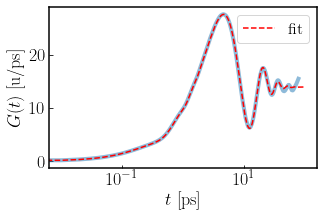

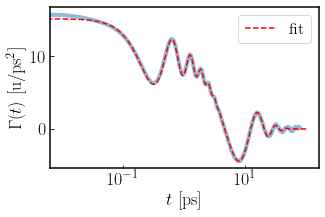

In [8]:
#fitting function is a sum of exponental-oscillation functions
def func_exp_ft(omega,*params):
    N = int(len(params)/3)
    func = np.zeros(len(omega)) + 1j*np.zeros(len(omega))
    for i in range(0,3*N,3):
        k,tau,w = params[i:i+3]
        func+= k/2*((1+1j/(w*tau))/(1/tau + 1j*w - 1j*omega)+((1-1j/(w*tau))/(1/tau - 1j*w - 1j*omega)))
        
    return func

def func_exp(t,*params):
    N = int(len(params)/3)
    func = np.zeros(len(t))
    for i in range(0,3*N,3):
        k,tau,w = params[i:i+3]
        func+= k*np.exp(-t/tau)*(np.cos(w*t) + 1/(w*tau)*np.sin(w*t))
        
    return func

def func_int_exp(t,*params):
   
    return integrate.cumtrapz(func_exp(t,*params), t, initial=0)


from filon_fft import *

def fit_func(t,*params):
    func1 = integrate.cumtrapz(func_exp(t,*params), t, initial=0)
    func2 = func_exp(t,*params)
    
    return np.append(func1, func2)

def fit_func2(omega,*params):
    func1 = func_exp_ft(omega,*params)
    
    return np.append(np.real(func1),np.imag(func1))

N = 3
dt=dt

lower_lim_k = 1e-2
lower_lim_tau = 5e-3
lower_lim_w = 0

upper_lim_k=1e7
upper_lim_tau = 5000
upper_lim_w = 3000
bounds = ([],[])

for i in range(N):
    bounds[0].append(lower_lim_k)
    bounds[0].append(lower_lim_tau)
    bounds[0].append(lower_lim_w)
    bounds[1].append(upper_lim_k)
    bounds[1].append(upper_lim_tau)
    bounds[1].append(upper_lim_w)
    



p0=(1,1,1,
      5,2,1,
      1,0.05,1)



popt = p0
popt, pcov = optimize.curve_fit(fit_func2, freqs_logsp*2*np.pi, np.append(np.real(kernel_ft_logsp),-np.imag(kernel_ft_logsp)),maxfev=10000,p0=popt,bounds = bounds) 


popt, pcov = optimize.curve_fit(fit_func, t_logsp, np.append(ikernel_logsp, kernel_logsp),maxfev=100000,p0=popt,bounds = bounds) 

print(popt)

'''
plt.plot(freqs_logsp,kernel_ft_logsp,lw=4,alpha=0.5)
plt.plot(freqs,func_exp_ft(freqs*np.pi*2,*popt),'r--',label='fit')
plt.plot(freqs_logsp,-np.imag(kernel_ft_logsp),lw=4,alpha=0.5)
plt.plot(freqs,np.imag(func_exp_ft(freqs*np.pi*2,*popt)),'g--',label='fit')
#plt.xscale('log')
#plt.xlim(0,30)
plt.xscale('log')
plt.show()
'''

plt.plot(t_logsp,ikernel_logsp,lw=4,alpha=0.5)
#plt.plot(t,func_int_exp(t,*popt),'r--')
plt.plot(t,integrate.cumtrapz(func_exp(t,*popt), t, initial=0),'r--',label='fit')
plt.xscale('log')
plt.xlabel('$t$ [ps]')
plt.ylabel('$G(t)$ [u/ps]')
plt.legend()
plt.show()

plt.plot(t_logsp,kernel_logsp,lw=4,alpha=0.5)
plt.plot(t,func_exp(t,*popt),'r--',label='fit')
plt.xscale('log')
plt.xlabel('$t$ [ps]')
plt.ylabel('$\Gamma(t)$ [u/ps$^2$]')
plt.legend()
plt.show()






### Perform Markovian Embedding 
we add high boundaries to the ends of the potential for numerical stability

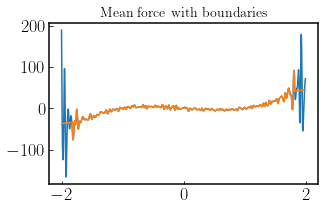

1.0109656720713418
13.906753950352778


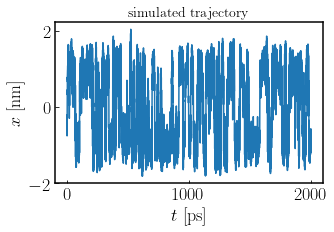

In [9]:
from gle_multi_exp_osc import *

def polynom(x,a,b):
    b = -np.abs(b)
    return(a*x+b*x**2)

def polynom2(x,a,b):
    b = np.abs(b)
    return(a*x+b*x**2)

nsteps=len(x)*5#int(2e7)
 
kT=2.494
dt=0.01

fe_spline,force_bins,force_matrix = spline_fe_for_sim(pos,fe)
start1 = 90
start2 = 90
popt1, pcov=optimize.curve_fit(polynom, force_bins[:start1], force_matrix[:start1])
popt2, pcov=optimize.curve_fit(polynom2, force_bins[-start2:], force_matrix[-start2:])

force_eff2 = force_matrix.copy()
force_eff2[:start1] = polynom(force_bins[:start1], *popt1)
force_eff2[-start2:] = polynom2(force_bins[-start2:], *popt2)
plt.title('Mean force with boundaries',fontsize=14)
plt.plot(force_bins,force_matrix)
plt.plot(force_bins,force_eff2)
plt.show()


force_matrix=force_eff2


mass = kT/corrv[0]
print(mass)

ks = popt[::3]
taus=popt[1::3]
ws=popt[2::3]


mys=ks*(taus**-2 + ws**2)**-1
gammays=2*mys/taus
print(np.sum(gammays))
n_exp = len(ks)
x0=np.mean(0)
v0=np.random.normal(0.0,math.sqrt(kT/mass))
y0=np.zeros(n_exp)
w0=np.zeros(n_exp)

'''
for j in range(n_exp):
    y0[j]=random.gauss(x0,math.sqrt(kT*np.absolute(taus[j]/gammays[j])))
    w0[j]=random.gauss(0.0,math.sqrt(kT/mys[j]))
'''
    
x_sim,vv,yy,ww = integrate_multi_exp_osc_arb_pot(nsteps, dt, mass, ks, mys, gammays, x0, y0, v0,w0, kT,force_bins,force_matrix)

start = 100
end = int(len(x_sim)*1)

x_sim = x_sim[start:end] #equilibrium time
t_sim = np.arange(0,len(x_sim)*dt,dt)


plt.plot(t_sim[:200000],x_sim[:200000])
plt.title('simulated trajectory',fontsize=14)
plt.xlabel(r'$t$ [ps]')
plt.ylabel(r'$x$ [nm]')
plt.show()


### Check Free Energy and Memory Kernel

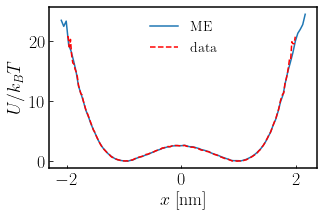

In [10]:
hist1,edges1=np.histogram(x_sim, bins=100, density=True)
pos1 =(edges1[1:]+edges1[:-1])/2
pos_sim = pos1
fe_sim = -np.log(hist1)*kT
fe_sim-=np.min(fe_sim)

plt.plot(pos_sim,fe_sim,label='ME')
plt.plot(pos,fe-np.min(fe),'r--',label='data')
plt.xlabel('$x$ [nm]')
plt.ylabel('$U/k_BT$')
plt.legend(loc='best',frameon=False,fontsize=14)
plt.show()

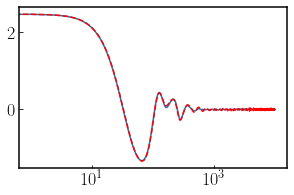

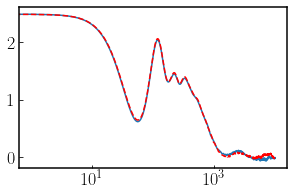

In [11]:
corrv_sim =correlation(np.gradient(x_sim,dt))[:int(trunc/dt)]
corrxU_sim =correlation(interpolate.splev(x_sim, fe_spline, der=1),x_sim)[:int(trunc/dt)]
corrxU_sim /=corrxU_sim[0]/kT

plt.plot(corrv_sim)
plt.plot(corrv,'r--')
plt.xscale('log')
plt.show()

plt.plot(corrxU_sim)
plt.plot(corrxU,'r--')
plt.xscale('log')
plt.show()


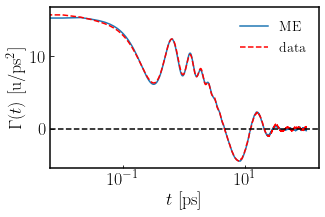

In [12]:
t_sim, kernel_sim, ikernel_sim = compute_kernel(dt, corrv_sim,corrxU_sim,kT/corrv_sim[0],trunc=10000,first_kind=True)

plt.plot(t_sim,kernel_sim,label='ME')
plt.plot(t,kernel,'r--',label='data',)
plt.xscale('log')
plt.xlabel('$t$ [ps]')
plt.ylabel('$\Gamma(t)$ [u/ps$^2$]')
plt.axhline(y=0,linestyle='--',color='k')
plt.legend(loc='best',frameon=False,fontsize=14)

### Check Statistical Key Observables (Mean-First-Passage Time for Different Starting Positions)

In [13]:
from calc_mpfts import *

xs1 = -1
xf1 = 1

radii = np.linspace(xs1,xf1,100)

mfpt, mfpt_std, counts = calc_mfpt(x, start=xs1, end=xf1, n_points=len(radii), dt=dt)
mfpt1 = np.zeros(len(radii))
mfpt2 = np.zeros(len(radii))

for j in range(len(mfpt1)):

        mfpt1[j] = np.nan_to_num(mfpt[0][j],0)
        mfpt2[j] = np.nan_to_num(mfpt[-1][j],0)
        
mfpt_sim, mfpt_std, counts = calc_mfpt(x_sim, start=xs1, end=xf1, n_points=len(radii), dt=dt)
mfpt1_sim = np.zeros(len(radii))
mfpt2_sim = np.zeros(len(radii))

for j in range(len(mfpt1)):

        mfpt1_sim[j] = np.nan_to_num(mfpt_sim[0][j],0)
        mfpt2_sim[j] = np.nan_to_num(mfpt_sim[-1][j],0)
        

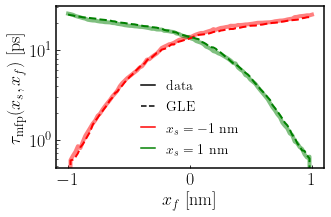

In [14]:
plt.plot(radii,mfpt1,'r',lw=4,alpha=0.5)
plt.plot(radii,mfpt2,'g',lw=4,alpha=0.5)
plt.plot(radii,mfpt1_sim,'r--',lw=2,alpha=1)
plt.plot(radii,mfpt2_sim,'g--',lw=2,alpha=1)
plt.plot([],[],color='k',label='data')
plt.plot([],[],color='k',linestyle='--',label='GLE')
plt.plot([],[],color='r',linestyle='-',label='$x_s = -1$ nm')
plt.plot([],[],color='g',linestyle='-',label='$x_s = 1$ nm')

plt.ylabel(r'$\tau_{\text{mfp}}(x_s,x_f)$ [ps]')
plt.xlabel('$x_f$ [nm]')
plt.yscale('log')
plt.legend(loc='best',frameon=False,fontsize=14,handlelength=1)
plt.show()